## Dynamic Topic Model
----
#### Notes
* Simple LDA treats a research abstract from 2000 the same as one from 2019 with respect to the term probabilities, so it is unable to learn that the term 'dsge' has declined in weight in the macro-modelling topic
* Topic representations evolve over fixed time intervals such as years. Specifically, the documents within each time slice are modeled with a topic model of the same dimension, and each topic in time slice $t$ evolves from a corresponding topic in time slice $t-1$.

In [1]:
import pandas as pd
import numpy as np
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('seaborn-bright')
import pprint
pp = pprint.PrettyPrinter(indent=4)
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy
from gensim.matutils import hellinger

#### Read in CB data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# add central bank identifiers
def cb_id(s):
    if 'Australia' in s:
        return 'RBA'
    elif 'US' in s:
        return 'US'
    elif 'European' in s:
        return 'ECB'
    elif 'Japan' in s:
        return 'BoJ'
    elif 'Canada' in s:
        return 'BoC'
    elif 'New Zealand' in s:
        return 'RBNZ'
    elif 'England' in s:
        return 'BoE'
    elif 'Sweden' in s:
        return 'Riksbank'
    elif 'Norges' in s:
        return 'Norges'
        
data['Central_Bank'] = data.ID.map(cb_id)

#### Some preliminary data cleaning
* remove papers with missing abstracts
* keep only abstracts from year 2000 onwards
* reset index

In [4]:
# remove papers where the abstract is not available
data          = data[data.Abstract != 'No abstract available']

# remove papers before 1998
data = data[data.Year > '1999']
data = data[data.Year != "undated"]

data.index = range(len(data))

#### Preprocessing function

In [5]:
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create English stop words list
en_stop = set(stopwords.words('english'))
# add context-specific stop words to list
en_stop = en_stop.union(["per","cent","one","two","three","four","five","six","seven","eight","nine","use",
                         "using","also","paper","results","evidence","suggests","implies","indicates","jel","find",
                         "finding",'hypothesis',"classification","area","effect",'discuss', 
                         "canada","canadian","australia","australian","japan","japanese","new zealand",
                         "swedish","sweden","norway","norwegian"])
    
def preprocess(s):
    
    # make lower case
    s = s.lower()
    
    # remove all numbers
    s = re.sub(r'[0-9]+', '', s)
       
    # create p_stemmer of class PorterStemmer
    p_stemmer  = PorterStemmer()
    
    # create lemmatizer of class WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tokenize string
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    s = token_pattern.findall(s)

    # remove stop words from tokens
    s = [i for i in s if not i in en_stop]
    
#     # stem words
#     s = [p_stemmer.stem(i) for i in s] 

    # lemmatize words
    s = [lemmatizer.lemmatize(i) for i in s] 
    
    return s

#### Sort data by year for the Dynamic Topic Model!

In [6]:
data = data.sort_values(by=['Year'])
data.head(1)

,Author/s,Year,Title,ID,Abstract,Central_Bank
3992,"Coenen, Günter, 2000.\n """,2000,Asymptotic confidence bands for the estimated ...,"9, European Central Bank.",This paper provides closed-form formulae for c...,ECB


In [7]:
abst = data.Abstract.map(preprocess)

#### Build LDA model
* **NB**: topic model has already been run 
* Just load the 'preliminary_LDA_v2.sav' model
* Have also experimented with a 15-topic model with very similar results

In [8]:
from gensim import corpora, models
dictionary = corpora.Dictionary(abst)

In [9]:
corpus     = [dictionary.doc2bow(text) for text in abst]

In [10]:
# import pickle
# filename     = 'preliminary_LDA_v2.sav'
# ldamodel     = pickle.load(open(filename, 'rb'))

#### Time slices

In [11]:
#time_slice = pd.DataFrame(data.Year.value_counts())
time_slice = pd.DataFrame(data.Year.value_counts().sort_index())
time_slice = time_slice.values.tolist()
time_slice = [item for sublist in time_slice for item in sublist]

In [12]:
# ldaseq = ldaseqmodel.LdaSeqModel(initialize='ldamodel', lda_model=ldamodel, num_topics=10, corpus=corpus, id2word=dictionary, time_slice=time_slice)

In [13]:
# filename     = 'dynamic_proper.sav'
# pickle.dump(ldaseq, open(filename, 'wb'))

In [14]:
import pickle
filename     = 'dynamic_proper.sav'
ldaseq       = pickle.load(open(filename, 'rb'))

In [15]:
# for given topic the word distribution over time
DTM_topic_0=ldaseq.print_topic_times(topic=0, top_terms=20)
DTM_topic_1=ldaseq.print_topic_times(topic=1, top_terms=20)
DTM_topic_2=ldaseq.print_topic_times(topic=2, top_terms=20)
DTM_topic_3=ldaseq.print_topic_times(topic=3, top_terms=20)
DTM_topic_4=ldaseq.print_topic_times(topic=4, top_terms=20)
DTM_topic_5=ldaseq.print_topic_times(topic=5, top_terms=20)
DTM_topic_6=ldaseq.print_topic_times(topic=6, top_terms=30)
DTM_topic_7=ldaseq.print_topic_times(topic=7, top_terms=20)
DTM_topic_8=ldaseq.print_topic_times(topic=8, top_terms=20)
DTM_topic_9=ldaseq.print_topic_times(topic=9, top_terms=20)

In [16]:
time_stamps=np.arange(int(data.Year.min(axis=0)),int(data.Year.max(axis=0))+1,1)
time_stamps=list(time_stamps)

In [17]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [18]:
# household sector
hs =ldaseq.print_topic_times(topic=6, top_terms=30)

hs_words_2000         = pd.DataFrame(hs[0]) 
hs_words_2000.columns = ['words', "weights"]
blankIndex=[''] * len(hs_words_2000)
hs_words_2000.index=blankIndex

hs_words_2010         = pd.DataFrame(hs[10])
hs_words_2010.columns = ['words', "weights"]
hs_words_2010.index=blankIndex

hs_words_2018         = pd.DataFrame(hs[18])
hs_words_2018.columns = ['words', "weights"]
hs_words_2018.index=blankIndex

display_side_by_side(hs_words_2000,hs_words_2010,hs_words_2018)

,words,weights
,rate,0.070773
,exchange,0.054342
,income,0.028010
,household,0.026235
,consumption,0.023736
,tax,0.020346
,currency,0.018773
,wealth,0.018358
,housing,0.011730
,saving,0.010860


In [19]:
# macro modelling
mm         =ldaseq.print_topic_times(topic=7, top_terms=30)

mm_words_2000         = pd.DataFrame(mm[0]) 
mm_words_2000.columns = ['words', "weights"]
blankIndex=[''] * len(mm_words_2000)
mm_words_2000.index=blankIndex

mm_words_2010         = pd.DataFrame(mm[10])
mm_words_2010.columns = ['words', "weights"]
mm_words_2010.index=blankIndex

mm_words_2018         = pd.DataFrame(mm[18])
mm_words_2018.columns = ['words', "weights"]
mm_words_2018.index=blankIndex

display_side_by_side(mm_words_2000,mm_words_2010,mm_words_2018)

,words,weights
,model,0.050847
,output,0.013848
,inflation,0.010764
,estimate,0.010417
,gap,0.008868
,equilibrium,0.008783
,data,0.008222
,approach,0.008062
,variable,0.007472
,test,0.007458


In [20]:
def topic_time(DTM_topic,time_stamps):  
    for i in range(len(time_slice)-1): # iterates through the years
        if i==0:
            temp_a1=pd.DataFrame(DTM_topic[i])            # first year word weights 
            temp_a2=pd.DataFrame(DTM_topic[i+1])          # second year word weights
            temp_a1.columns = ['words', time_stamps[i]]   # first year words
            temp_a2.columns = ['words', time_stamps[i+1]] # second year words
            temp_a1=pd.merge(temp_a1,temp_a2)             # merge on common words
        else:
            temp_a2=pd.DataFrame(DTM_topic[i+1])          # third year word weights
            temp_a2.columns = ['words', time_stamps[i+1]] # third year word weights
            temp_a1=pd.merge(temp_a1,temp_a2)             # merge on common words
    topic_words_time=temp_a1
    return topic_words_time
   
topic1_words_time=topic_time(DTM_topic_0,time_stamps) # banking sector
topic2_words_time=topic_time(DTM_topic_1,time_stamps) # financial markets
topic3_words_time=topic_time(DTM_topic_2,time_stamps) # financial stability risks
topic4_words_time=topic_time(DTM_topic_3,time_stamps) # corporate sector
topic5_words_time=topic_time(DTM_topic_4,time_stamps) # monetary policy transmission
topic6_words_time=topic_time(DTM_topic_5,time_stamps) # payments system
topic7_words_time=topic_time(DTM_topic_6,time_stamps) # household sector
topic8_words_time=topic_time(DTM_topic_7,time_stamps) # macro modelling
topic9_words_time=topic_time(DTM_topic_8,time_stamps) # inflation modelling
topic10_words_time=topic_time(DTM_topic_9,time_stamps) # external sector

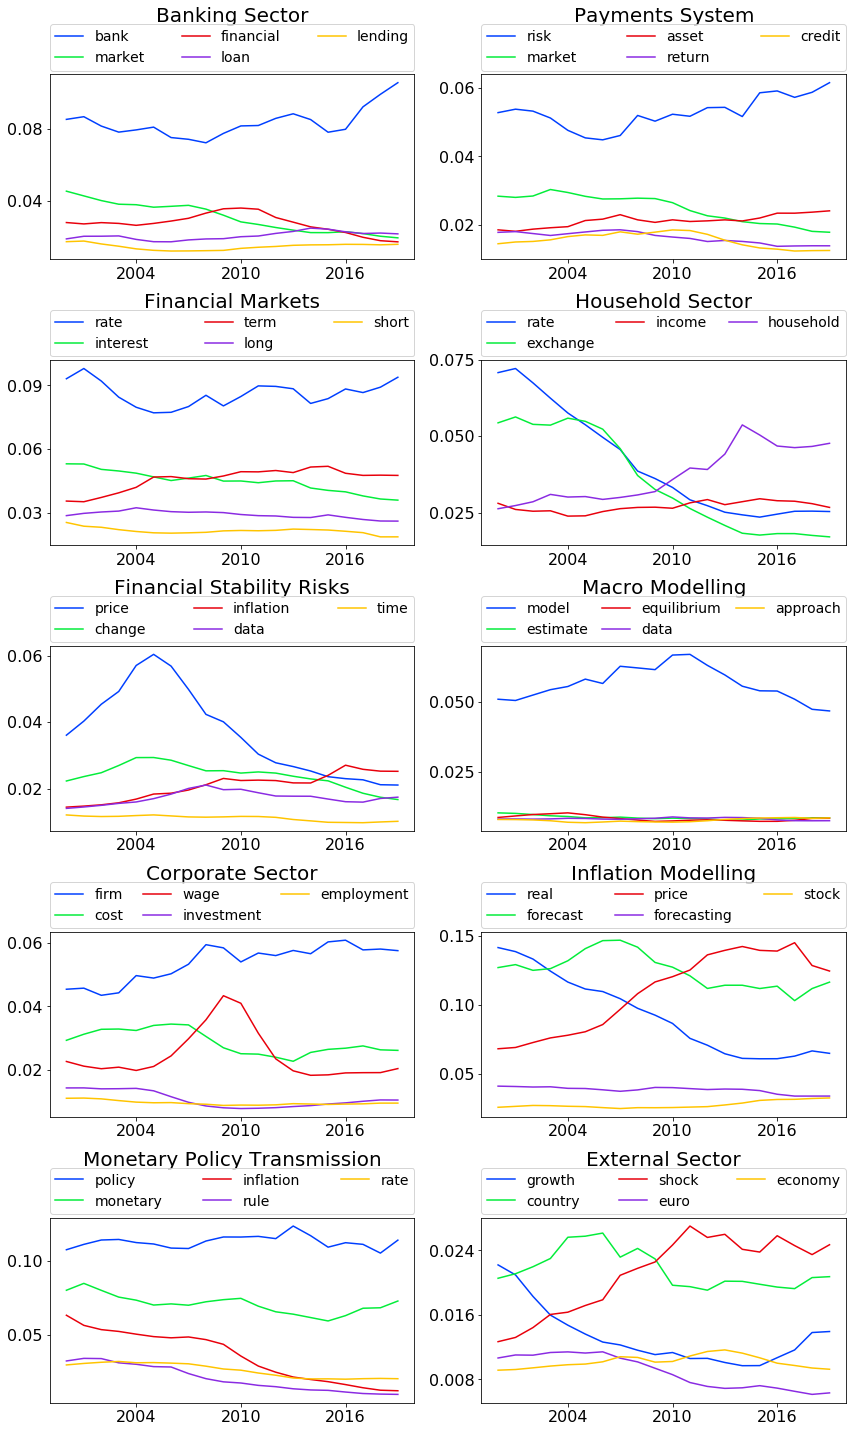

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,20))

ax11 = axes[0][0]
ax12 = axes[1][0]
ax13 = axes[2][0]
ax14 = axes[3][0]
ax15 = axes[4][0]

ax21 = axes[0][1]
ax22 = axes[1][1]
ax32 = axes[2][1]
ax42 = axes[3][1]
ax52 = axes[4][1]


for ax in [ax11, ax12, ax13, ax14, ax15, ax21, ax22, ax32, ax42, ax52]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

for i in [0,1,2,3,4]:
    topic=topic1_words_time
    topic_words=list(topic['words'])
    ax11.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax11.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax11.set_title('Banking Sector',fontsize = 20,y=1.25)
    
for i in [0,1,2,3,4]:
    topic=topic2_words_time
    topic_words=list(topic['words'])
    ax12.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax12.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax12.set_title('Financial Markets',fontsize = 20,y=1.25)
    
for i in [0,1,2,3,4]:
    topic=topic3_words_time
    topic_words=list(topic['words'])
    ax13.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax13.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax13.set_title('Financial Stability Risks',fontsize = 20,y=1.25)

for i in [0,1,2,3,4]:
    topic=topic4_words_time
    topic_words=list(topic['words'])
    ax14.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax14.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax14.set_title('Corporate Sector',fontsize = 20,y=1.25)

for i in [0,1,2,3,4]:
    topic=topic5_words_time
    topic_words=list(topic['words'])
    ax15.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax15.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax15.set_title('Monetary Policy Transmission',fontsize = 20,y=1.25)
    
for i in [0,1,2,3,4]:
    topic=topic6_words_time
    topic_words=list(topic['words'])
    ax21.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax21.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax21.set_title('Payments System',fontsize = 20,y=1.25)
    
for i in [0,1,2,3]:
    topic=topic7_words_time
    topic_words=list(topic['words'])
    ax22.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax22.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax22.set_title('Household Sector',fontsize = 20,y=1.25)
    
for i in [0,1,2,3,4]:
    topic=topic8_words_time
    topic_words=list(topic['words'])
    ax32.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax32.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax32.set_title('Macro Modelling',fontsize = 20,y=1.25)

for i in [0,1,2,3,4]:
    topic=topic9_words_time
    topic_words=list(topic['words'])
    ax42.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax42.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax42.set_title('Inflation Modelling',fontsize = 20,y=1.25)
    
for i in [0,1,2,3,4]:
    topic=topic10_words_time
    topic_words=list(topic['words'])
    ax52.plot(time_stamps, topic.ix[i,1:],label=topic_words[i])    
    ax52.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,fontsize=14)
    ax52.set_title('External Sector',fontsize = 20,y=1.25)
    
plt.tight_layout()
plt.savefig('full_dtm.pdf')
plt.show()

In [22]:
def plot_specific_topic(tn, term1 = '',term2 = '',term3 = '',title='',color1='b',color2='r',color3='b'):
    val_list1 = []
    val_list2 = []
    val_list3 = []
    for i in ldaseq.print_topic_times(topic=tn, top_terms=len(dictionary.values())):
        for each_tup in i:
            if each_tup[0] == term1:
                val_list1.append(each_tup[1])
            elif each_tup[0] == term2:
                val_list2.append(each_tup[1])
            elif each_tup[0] == term3:
                val_list3.append(each_tup[1])
            else: pass
    fig, ax = plt.subplots(figsize=(8,6))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_yticklabels([])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    ax.grid(False)
    plt.title(title,fontsize=20)
    ax.plot(val_list1,label=term1,color=color1)
    ax.plot(val_list2,label=term2,color=color2)
    ax.plot(val_list3,label=term3,color=color3)
    plt.legend(fontsize=28)
    plt.xlabel('Years',fontsize=20)
    plt.ylabel('Word importance',fontsize=20)
    plt.tight_layout()
    plt.savefig(term1+'.png')
    plt.show()

## Add topic number and word to explore the evolution of topics

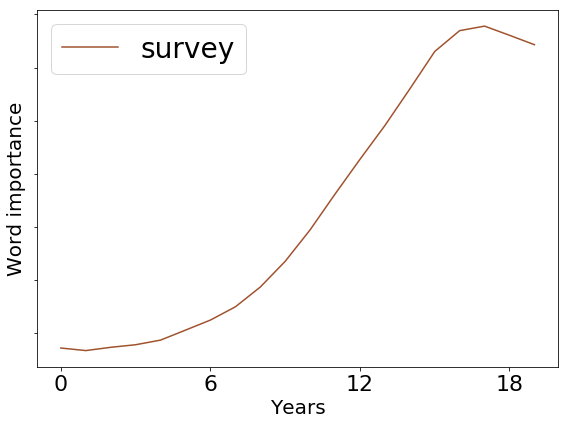

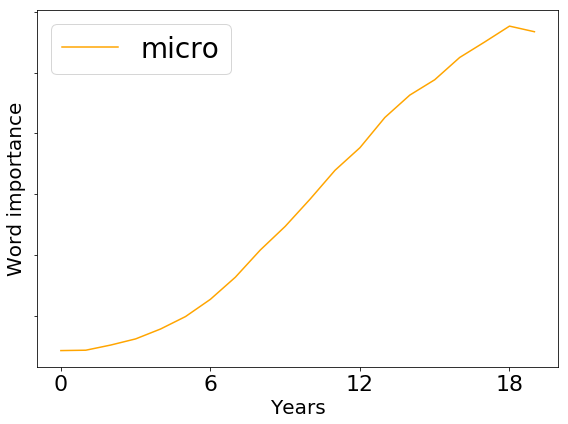

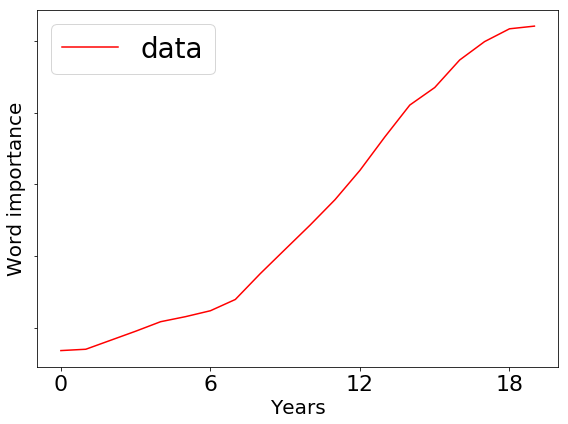

In [23]:
plot_specific_topic(6,term1 = 'survey',color1='sienna')

plot_specific_topic(6,term1 = 'micro',color1='orange')

plot_specific_topic(6,term1 = 'data',color1='r')

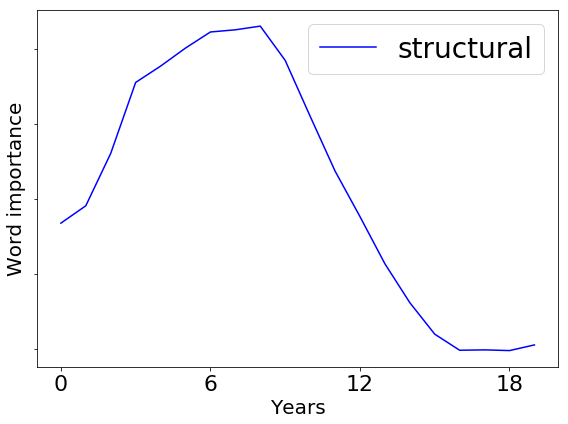

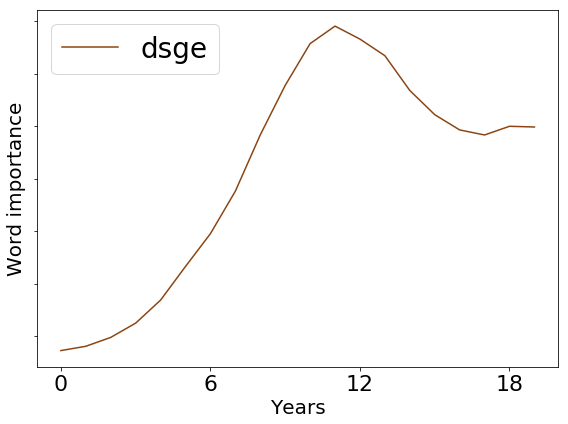

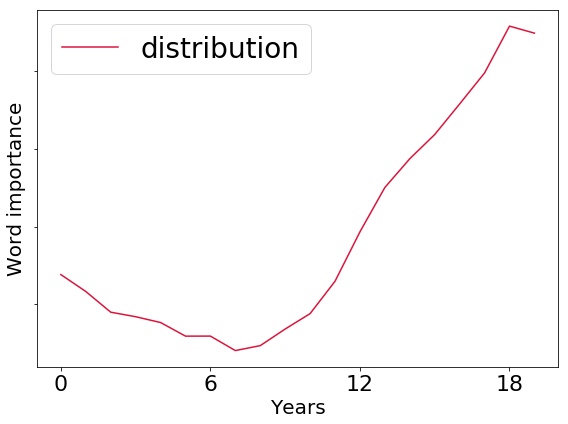

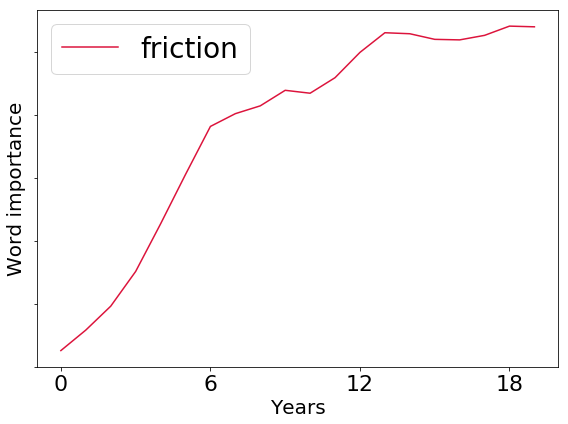

In [24]:
plot_specific_topic(7, term1 = 'structural',color1='b')
plot_specific_topic(7, term1 = 'dsge',color1='saddlebrown')
plot_specific_topic(7, term1 = 'distribution', color1='crimson')
plot_specific_topic(7, term1 = 'friction', color1='crimson')

#### Sources

* **Loading LDA to DTM:** https://github.com/MalishaB/Dynamic-Topic-Modelling/blob/master/Dynamic%20topic%20modelling.py
* **Full implementation: **https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html
* **Word evolutions: **https://github.com/XinwenNI/LDA-DTM/blob/master/LDA-DTM_Regulation_Risk/LDA-DTM_Policy_Risk_DTM.py
* **Topic importance: **https://github.com/d4gumich/pdf_dynamic_topic_modeling/blob/master/topic_modeling.ipynb
* **UN general database:** https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696